# 04. Custom Image Classification using CNN

This dataset contains 3 classes pizza, steak and sushi. We are going to create image classification model to classify these images. 

Random image path: data/pizza_steak_sushi/val/pizza/1152100.jpg
Image class: pizza
Image height: 384
Image width: 512


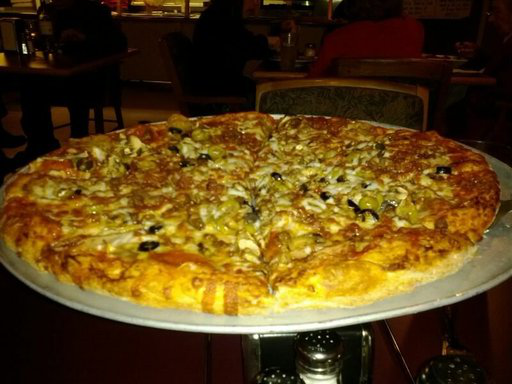

In [1]:
#Load Random Image

import random
from PIL import Image
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [2]:
%%writefile src/data_setup.py
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Create dataset and dataloader
def create_dataloaders(train_dir, 
                       val_dir, 
                       train_transform,
                       val_transform,
                       batch_size):
    
    # Create train, val dataset from custom images
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
    
    class_names = train_dataset.classes
    
    # Create train, val dataloader
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size,
        shuffle=True,
        pin_memory=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size,
        pin_memory=True
    )
    
    return train_dataloader, val_dataloader, class_names

Overwriting src/data_setup.py


In [3]:
%%writefile src/model_builder.py
import torch
from torch import nn

class ImageClassificationModel(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_channels):
        
        super().__init__()
        
        # Feature extraction layer 1
        self.layer_1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Feature extraction layer 2
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Classification layer
        self.layer_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_channels*16*16, output_channels)
        )
     
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

Overwriting src/model_builder.py


In [4]:
%%writefile src/engine.py
import torch

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

# Training loop using train dataloader
def train_step(
    model, 
    data_loader,
    loss_fn,
    optimizer,
    device
):

    model.train()
    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(data_loader):

        X = X.to(device)
        y = y.to(device)

        y_logits = model(X)

        loss = loss_fn(y_logits, y)
        train_loss = train_loss + loss

        acc = accuracy_fn(y, torch.argmax(y_logits, dim=1))
        train_acc = train_acc + acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)

    return train_loss, train_acc


# Validation loop using val dataloader
def val_step(
    model, 
    dataloader,
    loss_fn,
    device
):

    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X = X.to(device)
            y = y.to(device)

            y_logits = model(X)

            loss = loss_fn(y_logits, y)
            val_loss = val_loss + loss

            acc = accuracy_fn(y, torch.argmax(y_logits, dim=1))
            val_acc = val_acc + acc

        val_loss = val_loss / len(dataloader)
        val_acc = val_acc / len(dataloader)

    return val_loss, val_acc


def train(
    model, 
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    device,
    epochs
):
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in torch.arange(epochs):
    
        train_loss, train_acc = train_step(model, 
                                           train_dataloader, 
                                           loss_fn, 
                                           optimizer, 
                                           device)

        val_loss, val_acc = val_step(model, 
                                       val_dataloader, 
                                       loss_fn,
                                       device)
        
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'train_acc: {train_acc:.4f} | '
            f'test_loss: {val_loss:.4f} | '
            f'test_acc: {val_acc:.4f}'
        )

Overwriting src/engine.py


In [5]:
%%writefile src/utils.py
import torch
from pathlib import Path

# Save trained model 
def save_model(model,
               target_dir,
               model_name):


    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), 
               f=model_save_path)

Overwriting src/utils.py


In [6]:
%%writefile src/train.py
import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32
HIDDEN_UNITS = 20
LEARNING_RATE = 0.01

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
val_dir = "data/pizza_steak_sushi/val"

# Setup target device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Create train transform
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create val transform (no data augmentation)
val_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create training and validation dataloader
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    train_transform=train_transform_trivial_augment,
    val_transform=val_transform_trivial_augment,
    batch_size=BATCH_SIZE
)

# Create ImageClassificationModel
model = model_builder.ImageClassificationModel(
    input_channels=3,
    hidden_channels=HIDDEN_UNITS,
    output_channels=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model,
             train_dataloader,
             val_dataloader,
             loss_fn,
             optimizer,
             device,
             NUM_EPOCHS)

Overwriting src/train.py


In [7]:
%run -i 'src/train.py'

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Epoch: 1 | train_loss: 1.1519 | train_acc: 25.7812 | test_loss: 1.0982 | test_acc: 26.0417
Epoch: 2 | train_loss: 1.0997 | train_acc: 30.4688 | test_loss: 1.1000 | test_acc: 26.0417
Epoch: 3 | train_loss: 1.1034 | train_acc: 30.4688 | test_loss: 1.0960 | test_acc: 26.0417
Epoch: 4 | train_loss: 1.0958 | train_acc: 42.5781 | test_loss: 1.1011 | test_acc: 26.0417
Epoch: 5 | train_loss: 1.1015 | train_acc: 30.4688 | test_loss: 1.1044 | test_acc: 26.0417
Epoch: 6 | train_loss: 1.0997 | train_acc: 30.4688 | test_loss: 1.0986 | test_acc: 26.0417
Epoch: 7 | train_loss: 1.1036 | train_acc: 30.4688 | test_loss: 1.0932 | test_acc: 26.0417
Epoch: 8 | train_loss: 1.1014 | train_acc: 30.4688 | test_loss: 1.0955 | test_acc: 26.0417
Epoch: 9 | train_loss: 1.0996 | train_acc: 25.3906 | test_loss: 1.1016 | test_acc: 19.7917
Epoch: 10 | train_loss: 1.1021 | train_acc: 29.2969 | test_loss: 1.1063 | test_acc: 26.0417


As you see, our model's performance is not that good. We will use more sophisticated model in the next notebook.